In [12]:
# Imports necesarios

from pandas import to_datetime, read_csv # Trabajar con BDs
from sqlalchemy import create_engine # Para consultas
from sqlalchemy.types import DateTime, Integer # Especificar tipos al transformar BD
from datetime import date, datetime, timedelta # Para manejo de fechas, especialmente de headers

In [13]:
# Nombres auxiliares
# Cuarentenas: Fechas de inicio y término
qt = 'Cuarentenas totales'

# Contagio
ct = 'Casos totales' # Nota: Población por comuna se puede encontrar acá
ca = 'Casos actuales por fecha de inicio de síntomas'
cn = 'Casos nuevos por fecha de inicio de síntomas'
# Nota: Para tiempo de duplicación, utilizar Casos totales
vd = 'Viajes diarios' # Nota: Solo disponibles en RM

# Letalidad
dn = 'Decesos nuevos' # Nota: Disponible desde el 14 de junio

# Trazabilidad - Nada por comuna
# Disponibilidad - Nada por comuna
# Otros - Nada por comuna

# URLS DE DATOS REQUERIDOS
urls = {}
# Cuarentenas
urls[qt] = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto29/Cuarentenas-Totales.csv'
# Contagio
urls[ct] = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19.csv'
urls[ca] = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto25/CasosActualesPorComuna.csv'
urls[cn] = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto15/FechaInicioSintomas.csv'
urls[vd] = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto42/ViajesComunas_std.csv'
# Letalidad
urls[dn] = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto38/CasosFallecidosPorComuna.csv'
# Trazabilidad - Nada por comuna
# Disponibilidad - Nada por comuna
# Otros - Nada por comuna

In [36]:
# Funciones auxiliares
def get_csvs():
    '''Crea las bases de datos CSVs a partir de los repositorios''' 
    dbs = {}
    for abbr in urls.keys():
        dbs[abbr] = read_csv(urls[abbr], error_bad_lines=False)
    return dbs


def string_to_date(s):
    '''Convierte una fecha en un datetime'''
    return datetime(*(int(i) for i in s.split('-')))

def SE_to_date(s):
    '''Convierte una semana epidemiológica en una fecha'''
    print(s)
    return datetime(2020, 2, 15) + timedelta(7 * (int(s.split("SE")[1]) - 7))

def date_headers(abbv, date_from, date_to):
    return [col for col in dbs[abbv].columns if (
        ('2020-' in col) and ((string_to_date(col) >= date_from) and (string_to_date(col) <= date_to))
    )]

def SE_headers(abbv, date_from, date_to):
    return [col for col in dbs[abbv].columns if (
        ('SE' in col) and ((SE_to_date(col) >= date_from) and (SE_to_date(col) <= date_to))
    )]

def headers_to_col_query(l):
    return "`{}`".format("`, `".join(l))

In [37]:
# Datos
dbs = get_csvs()

# Engine para queries de SQLite
engine = create_engine('sqlite://', echo=False)

In [38]:
# Conversión de Fechas en Cuarentenas
dbs[qt]['Fecha de Inicio'] = to_datetime(dbs[qt]['Fecha de Inicio'])
dbs[qt]['Fecha de Término'] = to_datetime(dbs[qt]['Fecha de Término'])
# Conversión de Fechas en Viajes diarios
dbs['Viajes diarios']['Fecha'] = to_datetime(dbs['Viajes diarios']['Fecha'])

In [39]:
# Conversión de datos de CSV a SQL para hacer queries
dbs[qt].to_sql(qt, con=engine, dtype={
    'Fecha de Inicio': DateTime(),
    'Fecha de Término': DateTime(),
    'Código CUT Comuna': Integer()
})

dbs[ct].to_sql(ct, con=engine, dtype={
        'Codigo comuna': Integer(),
        'Poblacion': Integer()
    })

dbs['Casos actuales por fecha de inicio de síntomas'].to_sql('Casos actuales por fecha de inicio de síntomas', con=engine, dtype={
    'Codigo comuna': Integer(),
    'Poblacion': Integer()
})

dbs['Casos nuevos por fecha de inicio de síntomas'].to_sql('Casos nuevos por fecha de inicio de síntomas', con=engine, dtype={
    'Codigo comuna': Integer(),
    'Poblacion': Integer()
})

dbs['Viajes diarios'].to_sql('Viajes diarios', con=engine, dtype={
    'Fecha': DateTime(),
    'Viajes': Integer()
})

In [40]:
dbs[qt]

,ID,Nombre,Estado,Alcance,Fecha de Inicio,Fecha de Término,Código CUT Comuna,Detalle,Superficie en m2,Perímetro en m
0,1,Arica,Histórica,Área Urbana Completa,2020-04-16 22:00:00,2020-05-15 22:00:00,15101,Corresponde al Radio Urbano de la Ciudad de Ar...,2.805042e+07,48722.300013
1,2,Santiago Norte,Histórica,Sector Específico,2020-04-13 05:00:00,2020-05-05 22:00:00,13101,Corresponde a la extensión de la cuarentena en...,1.993922e+07,21599.351343
2,3,Puente Alto Poniente,Histórica,Sector Específico,2020-04-09 22:00:00,2020-05-08 22:00:00,13201,Corresponde al sector delimitado por la Av. Co...,4.236427e+07,30428.051523
3,4,El Bosque,Activa,Comuna completa,2020-04-16 22:00:00,2020-07-03 22:00:00,13105,Aplicada a la totalidad de la comuna. Se incor...,2.062271e+07,18788.870751
4,5,San Bernardo Nororiente,Histórica,Sector Específico,2020-04-16 22:00:00,2020-05-08 22:00:00,13401,Corresponde al sector delimitado por los limit...,1.632622e+07,24929.145720
...,...,...,...,...,...,...,...,...,...,...
93,94,Quillota,Activa,Comuna completa,2020-06-26 22:00:00,2020-07-03 22:00:00,5501,Aplicada a la totalidad de la comuna,4.288675e+08,107405.438298
94,95,Graneros,Activa,Comuna completa,2020-06-26 22:00:00,2020-07-03 22:00:00,6106,Aplicada a la totalidad de la comuna,1.640125e+08,67214.979391
95,96,Calera de Tango,Activa,Comuna completa,2020-06-26 22:00:00,2020-07-03 22:00:00,13403,Aplicada a la totalidad de la comuna,1.057834e+08,54220.992880
96,97,El Monte,Activa,Comuna completa,2020-06-26 22:00:00,2020-07-03 22:00:00,13602,Aplicada a la totalidad de la comuna,1.662576e+08,59682.034770


In [41]:
# Lista de (Cuarentenas de) Comunas Disponibles (TODO: Display)
comunas_disponibles = [i[0] for i in engine.execute("SELECT Nombre from '{}'".format(qt)).fetchall()]

In [42]:
# Selección de una de las (Cuarentenas de) Comunas (TODO: Choose)
comuna = comunas_disponibles[50]
comuna

'San Miguel'

In [43]:
# Datos de la Cuarentena Seleccionada
q_comuna = engine.execute("SELECT * from '{}' WHERE Nombre='{}';".format(qt, comuna)).fetchone()
cod_comuna = q_comuna['Código CUT Comuna']

# Fechas importantes a revisar
dia_inicio = q_comuna['Fecha de Inicio'].split(" ")[0]
dia_termino = q_comuna['Fecha de Término'].split(" ")[0]
# Antes de la cuarentena
pre_fecha_0 = string_to_date(dia_inicio) + timedelta(days=-14)
pre_fecha_1 = string_to_date(dia_inicio)
# Período de transición
trans_fecha_0 = string_to_date(dia_inicio)
trans_fecha_1 = string_to_date(dia_inicio) + timedelta(days=14)
# Período de plena cuarentena
tot_fecha_0 = string_to_date(dia_inicio) + timedelta(days=14)
tot_fecha_1 = string_to_date(dia_termino)
# Período de cuarentena efectiva
post_fecha_0 = string_to_date(dia_termino)
post_fecha_1 = string_to_date(dia_termino) + timedelta(days=14)

# Población de la comuna
poblacion = engine.execute("SELECT Poblacion from '{}' WHERE `Codigo comuna`='{}'".format(ct, cod_comuna)).fetchone()[0]

# q_comuna, pre_fecha_0

In [44]:
comunas = engine.execute("SELECT Nombre from '{}' WHERE `Código CUT Comuna`='{}'".format(qt, cod_comuna)).fetchall()
comunas = tuple([i[0] for i in comunas])


In [45]:
# Viajes donde la comuna es ORIGEN
if len(comunas) > 1:
    base_query = "SELECT Fecha, Origen, SUM(Viajes) from 'Viajes diarios' WHERE Origen IN {}".format(comunas) + " AND Fecha >= '{}' AND FECHA <= '{}' GROUP BY Fecha"
else:
    base_query = "SELECT Fecha, Origen, SUM(Viajes) from 'Viajes diarios' WHERE Origen='{}'".format(comunas[0]) + " AND Fecha >= '{}' AND FECHA <= '{}' GROUP BY Fecha"
pre_viajes_desde = engine.execute(base_query.format(pre_fecha_0, pre_fecha_1)).fetchall()
trans_viajes_desde = engine.execute(base_query.format(trans_fecha_0, trans_fecha_1)).fetchall()
tot_viajes_desde = engine.execute(base_query.format(tot_fecha_0, tot_fecha_1)).fetchall()
post_viajes_desde = engine.execute(base_query.format(post_fecha_0, post_fecha_1)).fetchall()

# Viajes donde la comuna es DESTINO
if len(comunas) > 1:
    base_query = "SELECT Fecha, Destino, SUM(Viajes) from 'Viajes diarios' WHERE Origen IN {}".format(comunas)
else:
    base_query = "SELECT Fecha, Destino, SUM(Viajes) from 'Viajes diarios' WHERE Origen='{}'".format(comunas[0])
base_query += " AND Fecha >= '{}' AND FECHA <= '{}' GROUP BY Fecha"
pre_viajes_hacia = engine.execute(base_query.format(pre_fecha_0, pre_fecha_1)).fetchall()
trans_viajes_hacia = engine.execute(base_query.format(trans_fecha_0, trans_fecha_1)).fetchall()
tot_viajes_hacia = engine.execute(base_query.format(tot_fecha_0, tot_fecha_1)).fetchall()
post_viajes_hacia = engine.execute(base_query.format(post_fecha_0, post_fecha_1)).fetchall()

#pre_viajes_hacia, trans_viajes_hacia, tot_viajes_hacia, post_viajes_hacia

In [46]:
dbs[ct]

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,2020-03-30,2020-04-01,2020-04-03,2020-04-06,2020-04-08,...,2020-05-29,2020-06-01,2020-06-05,2020-06-08,2020-06-12,2020-06-15,2020-06-19,2020-06-23,2020-06-28,Tasa
0,Arica y Parinacota,15,Arica,15101.0,247552.0,6.0,6.0,12.0,41.0,63.0,...,596.0,653.0,806.0,904.0,1046.0,1176.0,1371.0,1533.0,1758.0,710.2
1,Arica y Parinacota,15,Camarones,15102.0,1233.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arica y Parinacota,15,General Lagos,15202.0,810.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arica y Parinacota,15,Putre,15201.0,2515.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,3.0,9.0,10.0,11.0,437.4
4,Arica y Parinacota,15,Desconocido Arica y Parinacota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,Magallanes,12,Rio Verde,12103.0,211.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
384,Magallanes,12,San Gregorio,12104.0,681.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,293.7
385,Magallanes,12,Timaukel,12303.0,282.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
386,Magallanes,12,Torres del Paine,12402.0,1021.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
dates = [
    date_headers(ct, pre_fecha_0, pre_fecha_1),
    date_headers(ct, trans_fecha_0, trans_fecha_1),
    date_headers(ct, tot_fecha_0, tot_fecha_1),
    date_headers(ct, post_fecha_0, post_fecha_1)
]
pre_query, trans_query, tot_query, post_query = map(headers_to_col_query, dates)
pre_query, trans_query, tot_query, post_query

('`2020-04-24`, `2020-04-27`, `2020-05-01`, `2020-05-04`, `2020-05-08`',
 '`2020-05-08`, `2020-05-11`, `2020-05-15`, `2020-05-18`, `2020-05-22`',
 '`2020-05-22`, `2020-05-25`, `2020-05-29`, `2020-06-01`, `2020-06-05`, `2020-06-08`, `2020-06-12`, `2020-06-15`, `2020-06-19`, `2020-06-23`, `2020-06-28`',
 '``')

In [48]:
type(dates[1][0])

str

In [49]:
base_query = "SELECT {} from '{}' WHERE `Codigo comuna`='{}'"
pre_casos_totales = list(engine.execute(base_query.format(pre_query, ct, cod_comuna)).fetchone()) if len(pre_query) > 3 else []
trans_casos_totales = list(engine.execute(base_query.format(trans_query, ct, cod_comuna)).fetchone()) if len(trans_query) > 3 else []
tot_casos_totales = list(engine.execute(base_query.format(tot_query, ct, cod_comuna)).fetchone()) if len(tot_query) > 3 else []
post_casos_totales = list(engine.execute(base_query.format(post_query, ct, cod_comuna)).fetchone()) if len(post_query) > 3 else []

In [50]:
pre_casos_totales, trans_casos_totales, tot_casos_totales, post_casos_totales

([152.0, 173.0, 213.0, 255.0, 350.0],
 [350.0, 405.0, 563.0, 665.0, 1015.0],
 [1015.0,
  1205.0,
  1444.0,
  1687.0,
  1988.0,
  2286.0,
  2597.0,
  2796.0,
  3644.0,
  3945.0,
  4249.0],
 [])

In [51]:
dbs[ca]

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,2020-03-30,2020-04-01,2020-04-03,2020-04-06,2020-04-08,...,2020-05-29,2020-06-01,2020-06-05,2020-06-08,2020-06-12,2020-06-15,2020-06-19,2020-06-23,2020-06-28,Tasa
0,Arica y Parinacota,15,Arica,15101.0,247552.0,6.0,6.0,12.0,41.0,63.0,...,596.0,653.0,806.0,904.0,1046.0,1176.0,1371.0,1533.0,1758.0,710.2
1,Arica y Parinacota,15,Camarones,15102.0,1233.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arica y Parinacota,15,General Lagos,15202.0,810.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arica y Parinacota,15,Putre,15201.0,2515.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,3.0,9.0,10.0,11.0,437.4
4,Arica y Parinacota,15,Desconocido Arica y Parinacota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,Magallanes,12,Rio Verde,12103.0,211.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
384,Magallanes,12,San Gregorio,12104.0,681.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,293.7
385,Magallanes,12,Timaukel,12303.0,282.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
386,Magallanes,12,Torres del Paine,12402.0,1021.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
dates = [
    date_headers(ca, pre_fecha_0, pre_fecha_1),
    date_headers(ca, trans_fecha_0, trans_fecha_1),
    date_headers(ca, tot_fecha_0, tot_fecha_1),
    date_headers(ca, post_fecha_0, post_fecha_1)
]
pre_query, trans_query, tot_query, post_query = map(headers_to_col_query, dates)

pre_fechas = [string_to_date(i) for i in dates[0]]
trans_fechas = [string_to_date(i) for i in dates[1]]
tot_fechas = [string_to_date(i) for i in dates[2]]
post_fechas = [string_to_date(i) for i in dates[3]]
pre_fechas, trans_fechas, tot_fechas, post_fechas

([datetime.datetime(2020, 4, 24, 0, 0),
  datetime.datetime(2020, 4, 27, 0, 0),
  datetime.datetime(2020, 5, 1, 0, 0),
  datetime.datetime(2020, 5, 4, 0, 0),
  datetime.datetime(2020, 5, 8, 0, 0)],
 [datetime.datetime(2020, 5, 8, 0, 0),
  datetime.datetime(2020, 5, 11, 0, 0),
  datetime.datetime(2020, 5, 15, 0, 0),
  datetime.datetime(2020, 5, 18, 0, 0),
  datetime.datetime(2020, 5, 22, 0, 0)],
 [datetime.datetime(2020, 5, 22, 0, 0),
  datetime.datetime(2020, 5, 25, 0, 0),
  datetime.datetime(2020, 5, 29, 0, 0),
  datetime.datetime(2020, 6, 1, 0, 0),
  datetime.datetime(2020, 6, 5, 0, 0),
  datetime.datetime(2020, 6, 8, 0, 0),
  datetime.datetime(2020, 6, 12, 0, 0),
  datetime.datetime(2020, 6, 15, 0, 0),
  datetime.datetime(2020, 6, 19, 0, 0),
  datetime.datetime(2020, 6, 23, 0, 0),
  datetime.datetime(2020, 6, 28, 0, 0)],
 [])

In [57]:
base_query = "SELECT {} from '{}' WHERE `Codigo comuna`='{}'"
pre_casos_actuales = list(engine.execute(base_query.format(pre_query, ca, cod_comuna)).fetchone()) if len(pre_query) > 3 else []
trans_casos_actuales = list(engine.execute(base_query.format(trans_query, ca, cod_comuna)).fetchone()) if len(trans_query) > 3 else []
tot_casos_actuales = list(engine.execute(base_query.format(tot_query, ca, cod_comuna)).fetchone()) if len(tot_query) > 3 else []
post_casos_actuales = list(engine.execute(base_query.format(post_query, ca, cod_comuna)).fetchone()) if len(post_query) > 3 else []

In [58]:
pre_casos_actuales, trans_casos_actuales, tot_casos_actuales, post_casos_actuales

([152.0, 173.0, 213.0, 255.0, 350.0],
 [350.0, 405.0, 563.0, 665.0, 1015.0],
 [1015.0,
  1205.0,
  1444.0,
  1687.0,
  1988.0,
  2286.0,
  2597.0,
  2796.0,
  3644.0,
  3945.0,
  4249.0],
 [])

In [63]:
dbs[cn]

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,SE7,SE8,SE9,SE10,SE11,...,SE17,SE18,SE19,SE20,SE21,SE22,SE23,SE24,SE25,SE26
0,Antofagasta,2,Antofagasta,2101,425725.0,0.0,0.0,0.0,1.0,2.0,...,160.0,216.0,312.0,312.0,304.0,351.0,477.0,505.0,277.0,2.0
1,Antofagasta,2,Calama,2201,190336.0,0.0,1.0,1.0,0.0,2.0,...,38.0,53.0,91.0,235.0,280.0,435.0,748.0,786.0,373.0,6.0
2,Antofagasta,2,Maria Elena,2302,6814.0,0.0,0.0,1.0,0.0,0.0,...,16.0,47.0,39.0,30.0,13.0,12.0,11.0,6.0,18.0,0.0
3,Antofagasta,2,Mejillones,2102,14776.0,0.0,0.0,0.0,0.0,0.0,...,30.0,76.0,45.0,51.0,19.0,19.0,9.0,13.0,12.0,0.0
4,Antofagasta,2,Ollague,2202,287.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,Ñuble,16,San Ignacio,16108,16624.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,0.0,2.0,6.0,8.0,9.0,52.0,39.0,0.0
358,Ñuble,16,San Nicolas,16305,12172.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,3.0,9.0,8.0,9.0,5.0,3.0,0.0
359,Ñuble,16,Treguaco,16207,5696.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
360,Ñuble,16,Yungay,16109,18596.0,0.0,0.0,0.0,0.0,0.0,...,6.0,2.0,2.0,2.0,0.0,6.0,2.0,5.0,6.0,0.0


In [64]:
dates = [
    SE_headers(cn, pre_fecha_0, pre_fecha_1),
    SE_headers(cn, trans_fecha_0, trans_fecha_1),
    SE_headers(cn, tot_fecha_0, tot_fecha_1),
    SE_headers(cn, post_fecha_0, post_fecha_1)
]
pre_query, trans_query, tot_query, post_query = map(headers_to_col_query, dates)
pre_query, trans_query, tot_query, post_query

In [66]:
base_query = "SELECT {} from '{}' WHERE `Codigo comuna`='{}'"
pre_casos_nuevos = list(engine.execute(base_query.format(pre_query, cn, cod_comuna)).fetchone()) if len(pre_query) > 3 else []
trans_casos_nuevos = list(engine.execute(base_query.format(trans_query, cn, cod_comuna)).fetchone()) if len(trans_query) > 3 else []
tot_casos_nuevos = list(engine.execute(base_query.format(tot_query, cn, cod_comuna)).fetchone()) if len(tot_query) > 3 else []
post_casos_nuevos = list(engine.execute(base_query.format(post_query, cn, cod_comuna)).fetchone()) if len(post_query) > 3 else []

In [67]:
pre_casos_nuevos, trans_casos_nuevos, tot_casos_nuevos, post_casos_nuevos

([79.0, 203.0, 436.0],
 [436.0, 505.0, 612.0],
 [612.0, 589.0, 638.0, 448.0, 260.0, 0.0],
 [])

In [68]:
# Doubling time
data = cn
casos_por_fecha = engine.execute("SELECT * from '{}' WHERE `Codigo comuna`='{}'".format(data, q_comuna['Código CUT Comuna'])).fetchone()[6:-1]
fechas = [SE_to_date(i) for i in dbs[data].columns[5:-1]]
len(casos_por_fecha), len(fechas)
pre_query

'`SE17`, `SE18`, `SE19`'

In [69]:
import matplotlib
from matplotlib import pyplot

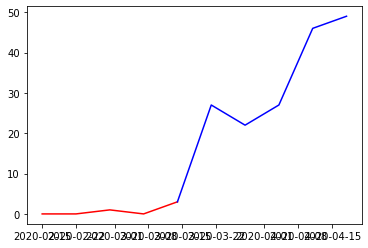

In [70]:
pyplot.plot(fechas[0:5], casos_por_fecha[0:5], color='red')
pyplot.plot(fechas[4:10], casos_por_fecha[4:10], color='blue')